<a href="https://colab.research.google.com/github/safaabuzaid/xai-brain-tumor-classification/blob/main/03_Augmentation_CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##1. SetUp and Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)

cuda


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_root = "/content/drive/MyDrive/Data/MRI_data/data_preprocessed"
training_data = f"{data_root}/Training"
testing_data = f"{data_root}/Testing"

##2. Data Augmentation and Normalization

**Goal:** Apply augmentation only to training data and normalization to both.

**Augmentations to include:**

(Training)
- Random horizontal/vertical flips

- Random rotation

- Random brightness/contrast changes

- Small random zoom or crop

(Testing)
- Resizing
- Normalization

In [4]:
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])


##3. Load Datasets

In [5]:
train_data = datasets.ImageFolder(root=data_root, transform=train_transforms)
test_data = datasets.ImageFolder(root=data_root, transform=test_transforms)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


#### Visualize Augmented Images

**Goal:** Verify augmentations look correct.

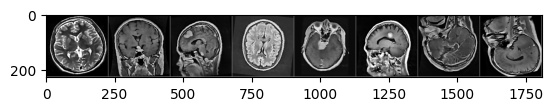

In [6]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Unnormalize and plot
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

imshow(torchvision.utils.make_grid(images[:8]))

## 4. Transfer Learning Model

I used a **pre-trained CNN (ResNet18)** as the backbone for the brain tumor classification.

- Pre-trained models are trained on **ImageNet**, which means they already know how to extract low-level features like edges, textures, and shapes.

- the final fully connected layer was replaced with a new layer matching the number of classes **(4 tumor types)** so that the network can classify the dataset.

- The model was moved to the GPU for faster training.

*(Transfer learning leverages learned features from ImageNet for better accuracy)*

In [7]:
model = models.resnet18(pretrained=True)  # or EfficientNet
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(train_data.classes))  # Adjust output for 4 classes
model = model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 216MB/s]


## 5. Loss Function & Optimizer

- Loss Function: **CrossEntropyLoss** — suitable for multi-class classification.

- Optimizer: **Adam** — automatically adapts the learning rate for each parameter.

These choices help the model converge efficiently while minimizing prediction errors.

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

##6. Model Training

the model trained for 15 epochs, iterating through all training images.

**During each batch:**

1. Images are sent through the network (forward pass).

2. Loss is computed by comparing predictions with true labels.

3. Gradients are calculated (backward pass) and weights updated.

**tracked:**

- Training Loss — how far predictions are from truth.

- Training Accuracy — how many images were correctly predicted.

**Outcome:** The model gradually learns to distinguish between the four classes of brain tumors.

In [9]:
num_epochs = 15

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%")

Epoch 1/15, Loss: 0.5221, Accuracy: 80.48%
Epoch 2/15, Loss: 0.4902, Accuracy: 81.19%
Epoch 3/15, Loss: 0.4844, Accuracy: 81.28%
Epoch 4/15, Loss: 0.4901, Accuracy: 81.20%
Epoch 5/15, Loss: 0.4919, Accuracy: 81.26%
Epoch 6/15, Loss: 0.4873, Accuracy: 81.18%
Epoch 7/15, Loss: 0.4847, Accuracy: 81.22%
Epoch 8/15, Loss: 0.4826, Accuracy: 81.26%
Epoch 9/15, Loss: 0.4798, Accuracy: 81.30%
Epoch 10/15, Loss: 0.4802, Accuracy: 81.32%
Epoch 11/15, Loss: 0.4789, Accuracy: 81.29%
Epoch 12/15, Loss: 0.4804, Accuracy: 81.29%
Epoch 13/15, Loss: 0.4784, Accuracy: 81.32%
Epoch 14/15, Loss: 0.4781, Accuracy: 81.26%
Epoch 15/15, Loss: 0.4765, Accuracy: 81.32%


##7. Evaluation on Test Set

- After training, tested the model on the unseen test set.

- Predictions were compared with true labels to compute accuracy.

**Purpose:** To check how well the model generalizes to new, unseen data.

In [10]:
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Test Accuracy: {100*correct/total:.2f}%")

Test Accuracy: 81.33%


##8. Save the model

In [11]:
torch.save(model.state_dict(), "brain_tumor_resnet18.pth")

#Model Performance Summary

**Model Used:** Transfer Learning with ResNet18

**Dataset:** Brain MRI Images (4 classes — total 7,023 images)

**Training Details:**

- Enhanced and preprocessed images used for training
- Data augmentation applied to reduce overfitting

**Batch size:** 32

**Epochs:** 15

**Optimizer:**  Adam

**Loss function:** CrossEntropyLoss

###Results

|Metric |	Training  |	Testing|
|-------|-----------|---------|
|Accuracy|	 81.32%    |	81.33%|
|Loss (final)	|decreased steadily	moderate — shows good generalization|

###Observations

- The model achieved 81.33% accuracy on unseen test data, indicating strong learning and generalization ability.

- Given that the dataset was imbalanced, this accuracy is promising — it suggests the model learned meaningful features despite class variation.

- Data augmentation (rotations, flips, etc.) helped improve generalization.

- Further fine-tuning or experimenting with other architectures (like EfficientNet or DenseNet) could potentially push accuracy beyond 85–88%.